Seismic data is a neat thing. You can imagine it like an ultra-sound of the subsurface. However, in an ultra-sound, we use much smaller wavelengths to image our body. Seismic data usually has wavelengths around 1m to 100m. That has some physical implications, but for now, we don't have to deal with that. It's just something to keep in mind while thinking about resolution. 

Imaging salt has been a huge topic in the seismic industry, basically since they imaged salt the first time. The Society of Exploration geophysicist alone has over 10,000 publications with the [keyword salt](https://library.seg.org/action/doSearch?AllField=salt). Salt bodies are important for the hydrocarbon industry, as they usually form nice oil traps. So there's a clear motivation to delineate salt bodies in the subsurface. If you would like to do a deep dive, you can see [this publication](https://www.iongeo.com/content/documents/Resource%20Center/Articles/INT_Imaging_Salt_tutorial_141101.pdf)

Seismic data interpreters are used to interpreting on 2D or 3D images that have been heavily processed. The standard work of [seismic data analysis](https://wiki.seg.org/wiki/Seismic_Data_Analysis) is open access.
You'll find sections on Salt in there as well (https://wiki.seg.org/wiki/Salt-flank_reflections and https://wiki.seg.org/wiki/Salt_flanks). The seismic itself is pretty "old" in the publication, and you're dealing with data that is less noisy here, which is nice.

[![Seismic Data with salt CC-BY-SA Yilmaz](https://wiki.seg.org/images/1/14/Ch05_fig0-1.png)](https://wiki.seg.org/wiki/Salt-flank_reflections#/media/File:Ch05_fig0-1.png)
Caption: Figure 5.0-1  Conflicting dips associated with salt flanks: (a) CMP stack without dip-moveout correction; (b) time migration of the stack in (a); (c) the stack with dip-moveout correction; (d) time migration of the stack in (c). CC-BY-SA Yilmaz.

Interpretation on seismic images has long used texture attributes, to identify better and highlight areas of interest. These can be seen like feature maps on the texture of the seismic. For salt, you will notice that the texture in the salt masks is rather chaotic, where the surrounding seismic is more "striped". You can think of Earth as layered. Sand gets deposited on top of existing sand. In comes salt, which is behaving very much, unlike other rocks. There is an entire research branch dedicated to salt tectonics, that is the movement of salt in the subsurface. To give you the gist, these salt diapirs form from salt layers somewhere else that were under much pressure. These started to flow (behave ductile) and find a way into other layers above. I have written a bit about salt on [my blog](http://the-geophysicist.com/the-showroom-data-for-my-thesis).

One common seismic attribute is called "chaos" or "seismic disorder". So if you talk to cynic geophysicists, you'll hear "that deep learning better outperform the Chaos attribute". A good starting point is [this publication](http://www.chopraseismic.com/wp-content/uploads/2016/08/Chopra_Marfurt_TLE_Aug2016-LowRes.pdf).

Recently, geoscience has started to adopt deep learning, and it has seen a clear boom, particularly in imaging salt. Code for automatic seismic interpretation can be found here: 

+ https://github.com/waldeland/CNN-for-ASI
+ https://github.com/bolgebrygg/MalenoV
+ https://github.com/crild/facies_net

You will notice that these solutions load a specific SEG-Y file, which luckily we don't have to bother with. TGS provided some nice PNG files instead. However, you can glean some information from them how to approach seismic data. If you find you need some geophysical helpers, you can [import Bruges](https://github.com/agile-geoscience/bruges)

Let's dive in for now.


In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [13]:
# Set some parameters
im_width = 128
im_height = 128
im_chan = 1
path_train = 'train/'
path_test = 'test/'

# Data Exploration
Let's look at some data. We can see that TGS chose to use very varied data by inspecting. That is great and adresses a problem in deep learning geoscience at the moment. We build models on one type of seismic and have no idea whether it generalizes.

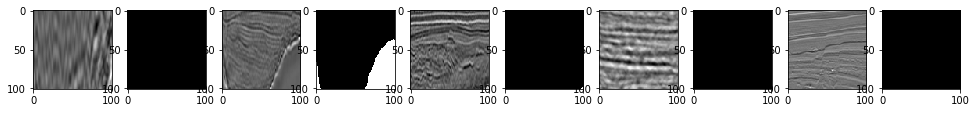

In [11]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('train/images/' + img_name + '.png')
    img_mask = load_img('train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

We have many examples without salt, as you can see by the masks that are entirely dark. That's great, an algorithm we build will then know that patches exist entirely without salt. Talk about biasing your data.

We can draw heavily on other work, instead of regurgitating the geophysics work that has been done before. I mentioned that seismic is kind of like ultrasound. So I had a look at https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

Let's throw a Unet at our data. I am blatanly stealing from Ketil at this point. All credit goes to him and his nice code.
First we'll need to get our data into a shape that works for U-Nets. That means, it should be a power of 2. Let's do it quick and dirty for now, but eventually, consider aliasing and all that fun.

In [14]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [15]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 



Done!


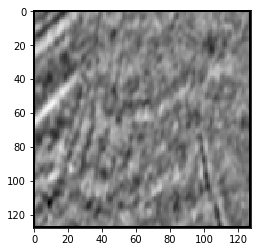

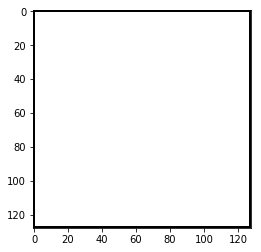

In [16]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

# Train Model
Our task, just like the segmentation task for nuclei, is evaluated on the mean IoU metric. This one isn't in keras, but obviously, we're stealing this one too from Ketil.

In [17]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

This is the fun part. Building the sequential Model. The U-Net is basically looking like an Auto-Encoder with shortcuts. 

We're also sprinkling in some earlystopping to prevent overfitting. If you're running this on kaggle, this is the point, you want to have GPU support.

In [18]:
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [19]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
3600/3600 [==============================] - ETA: 20:41 - loss: 0.6911 - mean_iou: 0.0000e+0 - ETA: 7:00 - loss: 0.6904 - mean_iou: 0.2737    - ETA: 3:33 - loss: 0.6893 - mean_iou: 0.33 - ETA: 2:24 - loss: 0.6849 - mean_iou: 0.35 - ETA: 1:50 - loss: 0.6825 - mean_iou: 0.35 - ETA: 1:29 - loss: 0.6788 - mean_iou: 0.36 - ETA: 1:15 - loss: 0.6493 - mean_iou: 0.36 - ETA: 1:05 - loss: 0.6549 - mean_iou: 0.36 - ETA: 58s - loss: 0.6614 - mean_iou: 0.3671 - ETA: 52s - loss: 0.6476 - mean_iou: 0.368 - ETA: 47s - loss: 0.6434 - mean_iou: 0.370 - ETA: 43s - loss: 0.6373 - mean_iou: 0.371 - ETA: 40s - loss: 0.6346 - mean_iou: 0.372 - ETA: 37s - loss: 0.6292 - mean_iou: 0.373 - ETA: 35s - loss: 0.6252 - mean_iou: 0.374 - ETA: 33s - loss: 0.6150 - mean_iou: 0.375 - ETA: 31s - loss: 0.6131 - mean_iou: 0.376 - ETA: 29s - loss: 0.6105 - mean_iou: 0.377 - ETA: 28s - loss: 0.6076 - mean_iou: 0.377 - ETA: 27s - loss: 0.6054 - mean_iou: 0.378 - ETA: 

3600/3600 [==============================] - ETA: 10s - loss: 0.4411 - mean_iou: 0.400 - ETA: 9s - loss: 0.3430 - mean_iou: 0.400 - ETA: 9s - loss: 0.4056 - mean_iou: 0.40 - ETA: 9s - loss: 0.4139 - mean_iou: 0.40 - ETA: 9s - loss: 0.4220 - mean_iou: 0.40 - ETA: 9s - loss: 0.4233 - mean_iou: 0.40 - ETA: 9s - loss: 0.4233 - mean_iou: 0.40 - ETA: 9s - loss: 0.4423 - mean_iou: 0.40 - ETA: 9s - loss: 0.4312 - mean_iou: 0.40 - ETA: 8s - loss: 0.4421 - mean_iou: 0.40 - ETA: 8s - loss: 0.4425 - mean_iou: 0.40 - ETA: 8s - loss: 0.4360 - mean_iou: 0.40 - ETA: 8s - loss: 0.4223 - mean_iou: 0.40 - ETA: 8s - loss: 0.4121 - mean_iou: 0.40 - ETA: 8s - loss: 0.4069 - mean_iou: 0.40 - ETA: 8s - loss: 0.3988 - mean_iou: 0.40 - ETA: 8s - loss: 0.3976 - mean_iou: 0.40 - ETA: 8s - loss: 0.3949 - mean_iou: 0.40 - ETA: 8s - loss: 0.3869 - mean_iou: 0.40 - ETA: 8s - loss: 0.3793 - mean_iou: 0.40 - ETA: 8s - loss: 0.3781 - mean_iou: 0.40 - ETA: 8s - loss: 0.3774 - mean_iou: 0.40 - ETA: 8s - loss: 0.3703 - mea

3600/3600 [==============================] - ETA: 9s - loss: 0.4898 - mean_iou: 0.47 - ETA: 9s - loss: 0.3154 - mean_iou: 0.47 - ETA: 9s - loss: 0.2952 - mean_iou: 0.47 - ETA: 8s - loss: 0.2873 - mean_iou: 0.47 - ETA: 8s - loss: 0.2845 - mean_iou: 0.47 - ETA: 8s - loss: 0.2810 - mean_iou: 0.47 - ETA: 8s - loss: 0.2909 - mean_iou: 0.47 - ETA: 8s - loss: 0.2835 - mean_iou: 0.47 - ETA: 8s - loss: 0.2945 - mean_iou: 0.47 - ETA: 8s - loss: 0.2867 - mean_iou: 0.47 - ETA: 8s - loss: 0.2876 - mean_iou: 0.47 - ETA: 8s - loss: 0.2973 - mean_iou: 0.47 - ETA: 8s - loss: 0.3007 - mean_iou: 0.47 - ETA: 8s - loss: 0.2974 - mean_iou: 0.47 - ETA: 8s - loss: 0.3096 - mean_iou: 0.47 - ETA: 8s - loss: 0.3128 - mean_iou: 0.47 - ETA: 8s - loss: 0.3131 - mean_iou: 0.47 - ETA: 8s - loss: 0.3223 - mean_iou: 0.47 - ETA: 8s - loss: 0.3289 - mean_iou: 0.47 - ETA: 8s - loss: 0.3288 - mean_iou: 0.47 - ETA: 7s - loss: 0.3292 - mean_iou: 0.47 - ETA: 7s - loss: 0.3317 - mean_iou: 0.48 - ETA: 7s - loss: 0.3254 - mean_i

3600/3600 [==============================] - ETA: 8s - loss: 0.1351 - mean_iou: 0.52 - ETA: 9s - loss: 0.2780 - mean_iou: 0.52 - ETA: 9s - loss: 0.2335 - mean_iou: 0.52 - ETA: 9s - loss: 0.2885 - mean_iou: 0.52 - ETA: 9s - loss: 0.2669 - mean_iou: 0.52 - ETA: 9s - loss: 0.2861 - mean_iou: 0.52 - ETA: 8s - loss: 0.2982 - mean_iou: 0.52 - ETA: 8s - loss: 0.3192 - mean_iou: 0.52 - ETA: 8s - loss: 0.3121 - mean_iou: 0.52 - ETA: 8s - loss: 0.3228 - mean_iou: 0.52 - ETA: 8s - loss: 0.3245 - mean_iou: 0.52 - ETA: 8s - loss: 0.3273 - mean_iou: 0.52 - ETA: 8s - loss: 0.3236 - mean_iou: 0.52 - ETA: 8s - loss: 0.3134 - mean_iou: 0.52 - ETA: 8s - loss: 0.3101 - mean_iou: 0.52 - ETA: 8s - loss: 0.3084 - mean_iou: 0.52 - ETA: 8s - loss: 0.2969 - mean_iou: 0.52 - ETA: 8s - loss: 0.2955 - mean_iou: 0.52 - ETA: 8s - loss: 0.2963 - mean_iou: 0.52 - ETA: 8s - loss: 0.2999 - mean_iou: 0.52 - ETA: 8s - loss: 0.3051 - mean_iou: 0.52 - ETA: 7s - loss: 0.3092 - mean_iou: 0.52 - ETA: 7s - loss: 0.3062 - mean_i

3600/3600 [==============================] - ETA: 10s - loss: 0.4846 - mean_iou: 0.553 - ETA: 10s - loss: 0.2526 - mean_iou: 0.553 - ETA: 10s - loss: 0.2743 - mean_iou: 0.553 - ETA: 9s - loss: 0.2479 - mean_iou: 0.553 - ETA: 9s - loss: 0.2551 - mean_iou: 0.55 - ETA: 9s - loss: 0.2675 - mean_iou: 0.55 - ETA: 9s - loss: 0.2525 - mean_iou: 0.55 - ETA: 9s - loss: 0.2498 - mean_iou: 0.55 - ETA: 9s - loss: 0.2714 - mean_iou: 0.55 - ETA: 9s - loss: 0.2642 - mean_iou: 0.55 - ETA: 8s - loss: 0.2577 - mean_iou: 0.55 - ETA: 8s - loss: 0.2528 - mean_iou: 0.55 - ETA: 8s - loss: 0.2443 - mean_iou: 0.55 - ETA: 8s - loss: 0.2360 - mean_iou: 0.55 - ETA: 8s - loss: 0.2315 - mean_iou: 0.55 - ETA: 8s - loss: 0.2343 - mean_iou: 0.55 - ETA: 8s - loss: 0.2354 - mean_iou: 0.55 - ETA: 8s - loss: 0.2427 - mean_iou: 0.55 - ETA: 8s - loss: 0.2574 - mean_iou: 0.55 - ETA: 8s - loss: 0.2608 - mean_iou: 0.55 - ETA: 8s - loss: 0.2639 - mean_iou: 0.55 - ETA: 8s - loss: 0.2636 - mean_iou: 0.55 - ETA: 7s - loss: 0.2629 -

3600/3600 [==============================] - ETA: 10s - loss: 0.1433 - mean_iou: 0.576 - ETA: 9s - loss: 0.1983 - mean_iou: 0.577 - ETA: 9s - loss: 0.2268 - mean_iou: 0.57 - ETA: 9s - loss: 0.2422 - mean_iou: 0.57 - ETA: 9s - loss: 0.2508 - mean_iou: 0.57 - ETA: 9s - loss: 0.2473 - mean_iou: 0.57 - ETA: 9s - loss: 0.2404 - mean_iou: 0.57 - ETA: 8s - loss: 0.2404 - mean_iou: 0.57 - ETA: 8s - loss: 0.2495 - mean_iou: 0.57 - ETA: 8s - loss: 0.2378 - mean_iou: 0.57 - ETA: 8s - loss: 0.2447 - mean_iou: 0.57 - ETA: 8s - loss: 0.2414 - mean_iou: 0.57 - ETA: 8s - loss: 0.2418 - mean_iou: 0.57 - ETA: 8s - loss: 0.2520 - mean_iou: 0.57 - ETA: 8s - loss: 0.2554 - mean_iou: 0.57 - ETA: 8s - loss: 0.2557 - mean_iou: 0.57 - ETA: 8s - loss: 0.2521 - mean_iou: 0.57 - ETA: 8s - loss: 0.2553 - mean_iou: 0.57 - ETA: 8s - loss: 0.2519 - mean_iou: 0.57 - ETA: 8s - loss: 0.2477 - mean_iou: 0.57 - ETA: 8s - loss: 0.2553 - mean_iou: 0.57 - ETA: 8s - loss: 0.2564 - mean_iou: 0.57 - ETA: 8s - loss: 0.2587 - mea

3600/3600 [==============================] - ETA: 8s - loss: 0.4954 - mean_iou: 0.59 - ETA: 9s - loss: 0.3593 - mean_iou: 0.59 - ETA: 9s - loss: 0.2981 - mean_iou: 0.59 - ETA: 9s - loss: 0.2709 - mean_iou: 0.59 - ETA: 9s - loss: 0.2693 - mean_iou: 0.59 - ETA: 9s - loss: 0.2562 - mean_iou: 0.59 - ETA: 9s - loss: 0.2418 - mean_iou: 0.59 - ETA: 8s - loss: 0.2481 - mean_iou: 0.59 - ETA: 8s - loss: 0.2473 - mean_iou: 0.59 - ETA: 8s - loss: 0.2602 - mean_iou: 0.59 - ETA: 8s - loss: 0.2496 - mean_iou: 0.59 - ETA: 8s - loss: 0.2442 - mean_iou: 0.59 - ETA: 8s - loss: 0.2398 - mean_iou: 0.59 - ETA: 8s - loss: 0.2452 - mean_iou: 0.59 - ETA: 8s - loss: 0.2444 - mean_iou: 0.59 - ETA: 8s - loss: 0.2499 - mean_iou: 0.59 - ETA: 8s - loss: 0.2460 - mean_iou: 0.59 - ETA: 8s - loss: 0.2456 - mean_iou: 0.59 - ETA: 8s - loss: 0.2409 - mean_iou: 0.59 - ETA: 8s - loss: 0.2412 - mean_iou: 0.59 - ETA: 8s - loss: 0.2450 - mean_iou: 0.59 - ETA: 8s - loss: 0.2404 - mean_iou: 0.59 - ETA: 7s - loss: 0.2388 - mean_i

3600/3600 [==============================] - ETA: 9s - loss: 0.4110 - mean_iou: 0.61 - ETA: 9s - loss: 0.3520 - mean_iou: 0.61 - ETA: 9s - loss: 0.2747 - mean_iou: 0.61 - ETA: 9s - loss: 0.2710 - mean_iou: 0.61 - ETA: 9s - loss: 0.2378 - mean_iou: 0.61 - ETA: 9s - loss: 0.2533 - mean_iou: 0.61 - ETA: 9s - loss: 0.2366 - mean_iou: 0.61 - ETA: 8s - loss: 0.2262 - mean_iou: 0.61 - ETA: 8s - loss: 0.2239 - mean_iou: 0.61 - ETA: 8s - loss: 0.2262 - mean_iou: 0.61 - ETA: 8s - loss: 0.2263 - mean_iou: 0.61 - ETA: 8s - loss: 0.2248 - mean_iou: 0.61 - ETA: 8s - loss: 0.2250 - mean_iou: 0.61 - ETA: 8s - loss: 0.2310 - mean_iou: 0.61 - ETA: 8s - loss: 0.2282 - mean_iou: 0.61 - ETA: 8s - loss: 0.2319 - mean_iou: 0.61 - ETA: 8s - loss: 0.2301 - mean_iou: 0.61 - ETA: 8s - loss: 0.2319 - mean_iou: 0.61 - ETA: 8s - loss: 0.2321 - mean_iou: 0.61 - ETA: 8s - loss: 0.2333 - mean_iou: 0.61 - ETA: 8s - loss: 0.2309 - mean_iou: 0.61 - ETA: 8s - loss: 0.2264 - mean_iou: 0.61 - ETA: 7s - loss: 0.2287 - mean_i

3600/3600 [==============================] - ETA: 9s - loss: 0.1299 - mean_iou: 0.63 - ETA: 9s - loss: 0.1845 - mean_iou: 0.63 - ETA: 9s - loss: 0.1640 - mean_iou: 0.63 - ETA: 9s - loss: 0.1929 - mean_iou: 0.63 - ETA: 9s - loss: 0.2064 - mean_iou: 0.63 - ETA: 9s - loss: 0.1982 - mean_iou: 0.63 - ETA: 8s - loss: 0.2041 - mean_iou: 0.63 - ETA: 8s - loss: 0.2142 - mean_iou: 0.63 - ETA: 8s - loss: 0.2205 - mean_iou: 0.63 - ETA: 8s - loss: 0.2183 - mean_iou: 0.63 - ETA: 8s - loss: 0.2395 - mean_iou: 0.63 - ETA: 8s - loss: 0.2371 - mean_iou: 0.63 - ETA: 8s - loss: 0.2324 - mean_iou: 0.63 - ETA: 8s - loss: 0.2332 - mean_iou: 0.63 - ETA: 8s - loss: 0.2291 - mean_iou: 0.63 - ETA: 8s - loss: 0.2280 - mean_iou: 0.63 - ETA: 8s - loss: 0.2283 - mean_iou: 0.63 - ETA: 8s - loss: 0.2376 - mean_iou: 0.63 - ETA: 8s - loss: 0.2284 - mean_iou: 0.63 - ETA: 8s - loss: 0.2230 - mean_iou: 0.63 - ETA: 8s - loss: 0.2158 - mean_iou: 0.63 - ETA: 8s - loss: 0.2236 - mean_iou: 0.63 - ETA: 7s - loss: 0.2206 - mean_i

3600/3600 [==============================] - ETA: 9s - loss: 0.2085 - mean_iou: 0.64 - ETA: 9s - loss: 0.2640 - mean_iou: 0.64 - ETA: 9s - loss: 0.2369 - mean_iou: 0.64 - ETA: 9s - loss: 0.2197 - mean_iou: 0.64 - ETA: 9s - loss: 0.2046 - mean_iou: 0.64 - ETA: 9s - loss: 0.2121 - mean_iou: 0.64 - ETA: 9s - loss: 0.1991 - mean_iou: 0.64 - ETA: 8s - loss: 0.1890 - mean_iou: 0.64 - ETA: 8s - loss: 0.1778 - mean_iou: 0.64 - ETA: 8s - loss: 0.1803 - mean_iou: 0.64 - ETA: 8s - loss: 0.1713 - mean_iou: 0.64 - ETA: 8s - loss: 0.1770 - mean_iou: 0.64 - ETA: 8s - loss: 0.1764 - mean_iou: 0.64 - ETA: 8s - loss: 0.1858 - mean_iou: 0.64 - ETA: 8s - loss: 0.1924 - mean_iou: 0.64 - ETA: 8s - loss: 0.1897 - mean_iou: 0.64 - ETA: 8s - loss: 0.1927 - mean_iou: 0.64 - ETA: 8s - loss: 0.1902 - mean_iou: 0.64 - ETA: 8s - loss: 0.1899 - mean_iou: 0.64 - ETA: 8s - loss: 0.1872 - mean_iou: 0.64 - ETA: 8s - loss: 0.1846 - mean_iou: 0.64 - ETA: 8s - loss: 0.1793 - mean_iou: 0.64 - ETA: 8s - loss: 0.1780 - mean_i

3600/3600 [==============================] - ETA: 10s - loss: 0.2315 - mean_iou: 0.660 - ETA: 9s - loss: 0.1253 - mean_iou: 0.660 - ETA: 9s - loss: 0.1261 - mean_iou: 0.66 - ETA: 9s - loss: 0.1069 - mean_iou: 0.66 - ETA: 9s - loss: 0.1442 - mean_iou: 0.66 - ETA: 9s - loss: 0.1528 - mean_iou: 0.66 - ETA: 9s - loss: 0.1428 - mean_iou: 0.66 - ETA: 9s - loss: 0.1391 - mean_iou: 0.66 - ETA: 8s - loss: 0.1404 - mean_iou: 0.66 - ETA: 8s - loss: 0.1537 - mean_iou: 0.66 - ETA: 8s - loss: 0.1494 - mean_iou: 0.66 - ETA: 8s - loss: 0.1449 - mean_iou: 0.66 - ETA: 8s - loss: 0.1403 - mean_iou: 0.66 - ETA: 8s - loss: 0.1406 - mean_iou: 0.66 - ETA: 8s - loss: 0.1393 - mean_iou: 0.66 - ETA: 8s - loss: 0.1371 - mean_iou: 0.66 - ETA: 8s - loss: 0.1378 - mean_iou: 0.66 - ETA: 8s - loss: 0.1376 - mean_iou: 0.66 - ETA: 8s - loss: 0.1329 - mean_iou: 0.66 - ETA: 8s - loss: 0.1309 - mean_iou: 0.66 - ETA: 8s - loss: 0.1297 - mean_iou: 0.66 - ETA: 8s - loss: 0.1351 - mean_iou: 0.66 - ETA: 7s - loss: 0.1440 - mea

3600/3600 [==============================] - ETA: 9s - loss: 0.4065 - mean_iou: 0.67 - ETA: 9s - loss: 0.1733 - mean_iou: 0.67 - ETA: 9s - loss: 0.1866 - mean_iou: 0.67 - ETA: 9s - loss: 0.1911 - mean_iou: 0.67 - ETA: 9s - loss: 0.1679 - mean_iou: 0.67 - ETA: 9s - loss: 0.1496 - mean_iou: 0.67 - ETA: 9s - loss: 0.1343 - mean_iou: 0.67 - ETA: 9s - loss: 0.1488 - mean_iou: 0.67 - ETA: 8s - loss: 0.1469 - mean_iou: 0.67 - ETA: 8s - loss: 0.1507 - mean_iou: 0.67 - ETA: 8s - loss: 0.1718 - mean_iou: 0.67 - ETA: 8s - loss: 0.1658 - mean_iou: 0.67 - ETA: 8s - loss: 0.1597 - mean_iou: 0.67 - ETA: 8s - loss: 0.1600 - mean_iou: 0.67 - ETA: 8s - loss: 0.1590 - mean_iou: 0.67 - ETA: 8s - loss: 0.1595 - mean_iou: 0.67 - ETA: 8s - loss: 0.1774 - mean_iou: 0.67 - ETA: 8s - loss: 0.1739 - mean_iou: 0.67 - ETA: 8s - loss: 0.1740 - mean_iou: 0.67 - ETA: 8s - loss: 0.1725 - mean_iou: 0.67 - ETA: 8s - loss: 0.1735 - mean_iou: 0.67 - ETA: 8s - loss: 0.1701 - mean_iou: 0.67 - ETA: 7s - loss: 0.1686 - mean_i

3600/3600 [==============================] - ETA: 9s - loss: 0.2133 - mean_iou: 0.68 - ETA: 9s - loss: 0.1688 - mean_iou: 0.68 - ETA: 9s - loss: 0.1660 - mean_iou: 0.68 - ETA: 9s - loss: 0.1516 - mean_iou: 0.68 - ETA: 9s - loss: 0.1431 - mean_iou: 0.68 - ETA: 9s - loss: 0.1370 - mean_iou: 0.68 - ETA: 9s - loss: 0.1368 - mean_iou: 0.68 - ETA: 8s - loss: 0.1436 - mean_iou: 0.68 - ETA: 8s - loss: 0.1394 - mean_iou: 0.68 - ETA: 8s - loss: 0.1323 - mean_iou: 0.68 - ETA: 8s - loss: 0.1308 - mean_iou: 0.68 - ETA: 8s - loss: 0.1395 - mean_iou: 0.68 - ETA: 8s - loss: 0.1381 - mean_iou: 0.68 - ETA: 8s - loss: 0.1379 - mean_iou: 0.68 - ETA: 8s - loss: 0.1371 - mean_iou: 0.68 - ETA: 8s - loss: 0.1351 - mean_iou: 0.68 - ETA: 8s - loss: 0.1337 - mean_iou: 0.68 - ETA: 8s - loss: 0.1313 - mean_iou: 0.68 - ETA: 8s - loss: 0.1336 - mean_iou: 0.68 - ETA: 8s - loss: 0.1321 - mean_iou: 0.68 - ETA: 8s - loss: 0.1335 - mean_iou: 0.68 - ETA: 8s - loss: 0.1329 - mean_iou: 0.68 - ETA: 8s - loss: 0.1412 - mean_i

3600/3600 [==============================] - ETA: 9s - loss: 0.0760 - mean_iou: 0.69 - ETA: 9s - loss: 0.0874 - mean_iou: 0.69 - ETA: 9s - loss: 0.1136 - mean_iou: 0.69 - ETA: 9s - loss: 0.1087 - mean_iou: 0.69 - ETA: 9s - loss: 0.1067 - mean_iou: 0.69 - ETA: 9s - loss: 0.1137 - mean_iou: 0.69 - ETA: 9s - loss: 0.1086 - mean_iou: 0.69 - ETA: 9s - loss: 0.1202 - mean_iou: 0.69 - ETA: 9s - loss: 0.1339 - mean_iou: 0.69 - ETA: 9s - loss: 0.1314 - mean_iou: 0.69 - ETA: 8s - loss: 0.1449 - mean_iou: 0.69 - ETA: 8s - loss: 0.1410 - mean_iou: 0.69 - ETA: 8s - loss: 0.1368 - mean_iou: 0.69 - ETA: 8s - loss: 0.1403 - mean_iou: 0.69 - ETA: 8s - loss: 0.1406 - mean_iou: 0.69 - ETA: 8s - loss: 0.1385 - mean_iou: 0.69 - ETA: 8s - loss: 0.1367 - mean_iou: 0.69 - ETA: 8s - loss: 0.1356 - mean_iou: 0.69 - ETA: 8s - loss: 0.1332 - mean_iou: 0.69 - ETA: 8s - loss: 0.1347 - mean_iou: 0.69 - ETA: 8s - loss: 0.1383 - mean_iou: 0.69 - ETA: 8s - loss: 0.1390 - mean_iou: 0.69 - ETA: 8s - loss: 0.1392 - mean_i

# Test Data
First we'll get the test data. This takes a while, it's 18000 samples.

In [20]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 



Done!


In [21]:
# Predict on train, val and test
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - ETA: 15 - ETA: 11 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:

In [22]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [23]:
preds_test_upsampled[0].shape

(101, 101)

We'll look at it again, just to be sure.

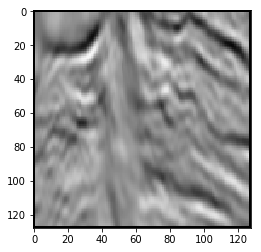

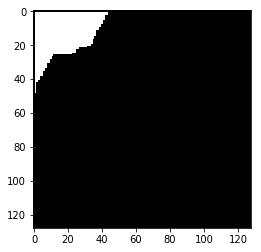

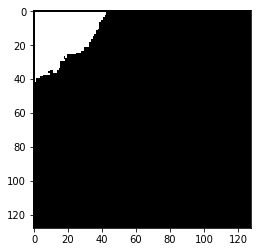

In [24]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

# Prepare Submission
We need to prepare the submission. A nice CSV with predictions. All of this is one to one from Ketil and does not differ from any of the other segmentation tasks. Check them out to improve on this.

In [25]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}

In [26]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')